##**Реализация задачи классификации с использованием библиотеки PyTorch**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision pillow matplotlib

##Импорт необходимых модулей
Добавлена магическая команда **"%matplotlib inline"** для отображения графиков.

Включен интерактивный режим прямо в ячейке **"plt.ion()"**

Всего изображений в датасете: 3670
Используемое устройство: cpu


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

Epoch [1/20]
Train Loss: 1.1426, Train Acc: 75.07%
Val Loss: 0.3555, Val Acc: 88.42%
------------------------------------------------------------
Epoch [2/20]
Train Loss: 0.8818, Train Acc: 85.15%
Val Loss: 0.3181, Val Acc: 88.96%
------------------------------------------------------------
Epoch [3/20]
Train Loss: 0.8343, Train Acc: 87.70%
Val Loss: 0.2723, Val Acc: 91.55%
------------------------------------------------------------
Epoch [4/20]
Train Loss: 0.8214, Train Acc: 87.94%
Val Loss: 0.2798, Val Acc: 88.96%
------------------------------------------------------------
Epoch [5/20]
Train Loss: 0.7710, Train Acc: 89.48%
Val Loss: 0.2547, Val Acc: 91.14%
------------------------------------------------------------
Epoch [6/20]
Train Loss: 0.7521, Train Acc: 89.48%
Val Loss: 0.2520, Val Acc: 91.28%
------------------------------------------------------------
Ранняя остановка на эпохе 6


<ipython-input-4-4e8afbe2bc38>:181: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
<ipython-input-4-4e8afbe2bc38>:194: Mat

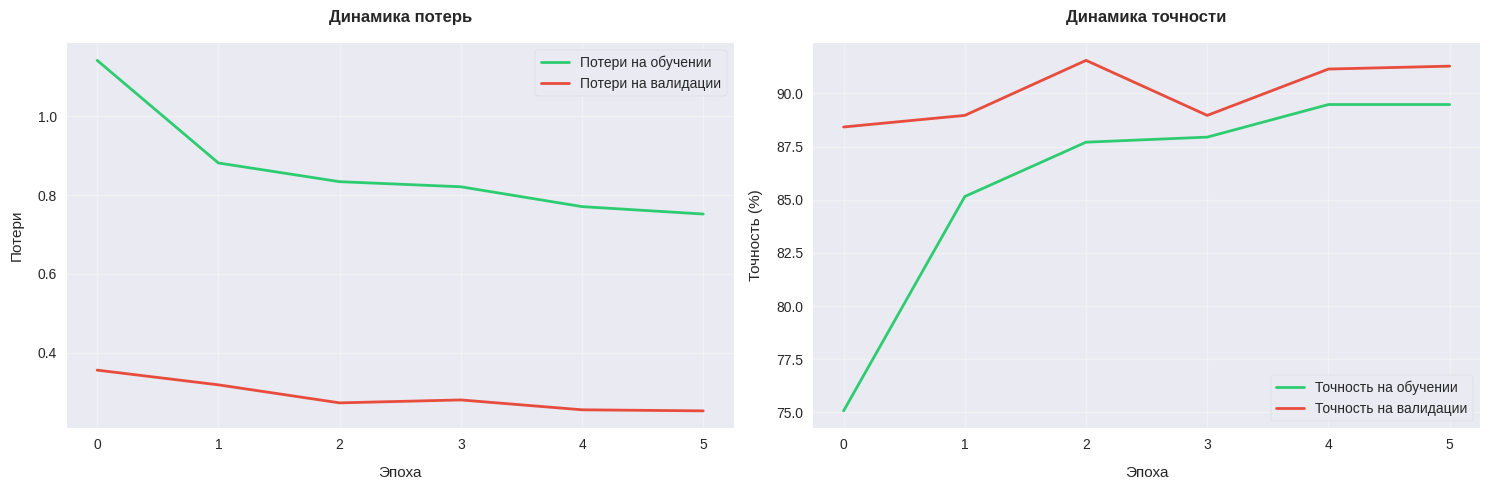


Финальные результаты:
Точность на обучении: 89.48%
Точность на валидации: 91.28%
Потери на обучении: 0.7521
Потери на валидации: 0.2520

Предсказанный класс: roses
Уверенность: 97.47%


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()  # Включаем интерактивный режим
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
import numpy as np
import os
import tarfile
import urllib.request
from PIL import Image

# 1. Загрузка и распаковка датасета
def download_and_extract_dataset(url, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Загрузка архива
    filename = url.split('/')[-1]
    filepath = os.path.join(target_dir, filename)

    if not os.path.exists(filepath):
        print("Загрузка датасета...")
        urllib.request.urlretrieve(url, filepath)

    # Распаковка
    if not os.path.exists(os.path.join(target_dir, "flower_photos")):
        print("Распаковка архива...")
        with tarfile.open(filepath, 'r:gz') as tar:
            tar.extractall(target_dir)

    return os.path.join(target_dir, "flower_photos")

# 2. Подсчет изображений
def count_images(dataset_path):
    total_images = 0
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                total_images += 1
    return total_images


# Улучшенная модель на основе ResNet18
class ImprovedFlowerClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedFlowerClassifier, self).__init__()
        # Загружаем предобученную ResNet18
        self.resnet = resnet18(pretrained=True)

        # Замораживаем веса базовой модели
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Заменяем последний слой на новый для нашей задачи
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# Преобразования данных с аугментацией
def get_transforms(is_training=True):
    if is_training:
        return transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

# Функция обучения с ранней остановкой
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs, device, patience=3):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_acc = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        # Обучение
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Добавляем L2 регуляризацию
            l2_lambda = 0.001
            l2_reg = torch.tensor(0.).to(device)
            for param in model.parameters():
                l2_reg += torch.norm(param)
            loss += l2_lambda * l2_reg

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Валидация
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Планировщик скорости обучения
        scheduler.step(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 60)

        # Ранняя остановка
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Сохраняем лучшую модель
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Ранняя остановка на эпохе {epoch+1}')
                break

    # Загружаем лучшую модель
    model.load_state_dict(torch.load('best_model.pth'))
    return train_losses, val_losses, train_accuracies, val_accuracies

def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Визуализирует результаты обучения: графики потерь и точности

    Args:
        train_losses: список потерь на обучающей выборке
        val_losses: список потерь на валидационной выборке
        train_accuracies: список значений точности на обучающей выборке
        val_accuracies: список значений точности на валидационной выборке
    """
    plt.style.use('seaborn')  # Используем стиль seaborn для более красивых графиков
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # График потерь
    ax1.plot(train_losses, label='Потери на обучении', color='#2ecc71', linewidth=2)
    ax1.plot(val_losses, label='Потери на валидации', color='#e74c3c', linewidth=2)
    ax1.set_title('Динамика потерь', pad=15, fontsize=12, fontweight='bold')
    ax1.set_xlabel('Эпоха', labelpad=10)
    ax1.set_ylabel('Потери', labelpad=10)
    ax1.legend(frameon=True)
    ax1.grid(True, alpha=0.3)

    # График точности
    ax2.plot(train_accuracies, label='Точность на обучении', color='#2ecc71', linewidth=2)
    ax2.plot(val_accuracies, label='Точность на валидации', color='#e74c3c', linewidth=2)
    ax2.set_title('Динамика точности', pad=15, fontsize=12, fontweight='bold')
    ax2.set_xlabel('Эпоха', labelpad=10)
    ax2.set_ylabel('Точность (%)', labelpad=10)
    ax2.legend(frameon=True)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Вывод финальных значений
    print(f"\nФинальные результаты:")
    print(f"Точность на обучении: {train_accuracies[-1]:.2f}%")
    print(f"Точность на валидации: {val_accuracies[-1]:.2f}%")
    print(f"Потери на обучении: {train_losses[-1]:.4f}")
    print(f"Потери на валидации: {val_losses[-1]:.4f}")

def predict_image(model, image_path, transform, device, class_names):
    """
    Выполняет предсказание класса для одного изображения

    Args:
        model: обученная модель
        image_path: путь к изображению
        transform: преобразования для изображения
        device: устройство (cpu/cuda)
        class_names: список названий классов

    Returns:
        tuple: (предсказанный класс, уверенность предсказания)
    """
    # Загрузка и преобразование изображения
    try:
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)

        # Предсказание
        model.eval()
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

        return class_names[predicted.item()], confidence.item()

    except Exception as e:
        print(f"Ошибка при обработке изображения: {str(e)}")
        return None, None

def main():
    # Параметры
    DATASET_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
    DATA_DIR = "./flower_data"
    BATCH_SIZE = 32
    NUM_EPOCHS = 20
    LEARNING_RATE = 0.001

    # Загрузка датасета
    dataset_path = download_and_extract_dataset(DATASET_URL, DATA_DIR)
    total_images = count_images(dataset_path)
    print(f"Всего изображений в датасете: {total_images}")

    # Создание датасетов с разными преобразованиями
    train_transform = get_transforms(is_training=True)
    val_transform = get_transforms(is_training=False)

    full_dataset = ImageFolder(dataset_path, transform=train_transform)

    # Разделение на обучающую и валидационную выборки
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Применяем разные преобразования
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform

    # Создание загрузчиков данных
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4)

    # Устройство для обучения
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Используемое устройство: {device}")

    # Создание модели
    model = ImprovedFlowerClassifier(num_classes=len(full_dataset.classes)).to(device)

    # Критерий и оптимизатор
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

    # Планировщик скорости обучения
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                   patience=2, verbose=True)

    # Обучение модели
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        NUM_EPOCHS, device
    )

    # Визуализация результатов
    plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

    # Пример инференса
    test_image_path = "/content/2024-10-28 105616.jpg"  # путь к тестовому изображению
    if os.path.exists(test_image_path):
        predicted_class, confidence = predict_image(
            model,
            test_image_path,
            val_transform,  # используем преобразования для валидации
            device,
            full_dataset.classes
        )
        if predicted_class is not None:
            print(f"\nПредсказанный класс: {predicted_class}")
            print(f"Уверенность: {confidence:.2%}")
    else:
        print(f"Файл {test_image_path} не найден")

if __name__ == "__main__":
    main()


##**Пример инференса.** Было использовано фото:
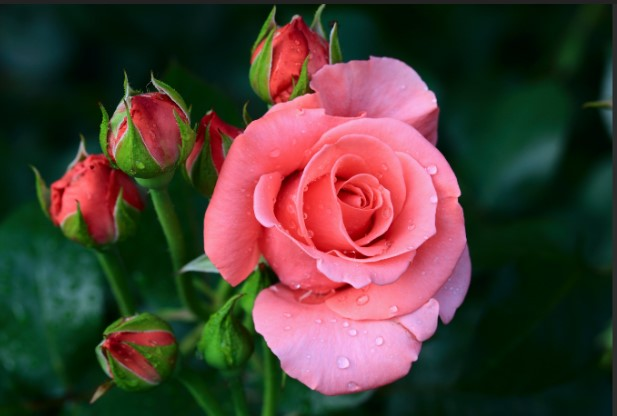

*Рис. 1 Роза крупным планом*

##**Краткое описание основных компонентов:**
###**1. Загрузка и подготовка данных:**
   - Автоматическая загрузка и распаковка датасета
   - Подсчет количества изображений
   - Разделение на обучающую и валидационную выборки (80/20)

###**2. Архитектура модели:**
   - Использование предобученной ResNet18
   - Замораживание весов базовой модели
   - Добавление dropout для борьбы с переобучением

###**3. Аугментация данных:**
   - Случайное изменение размера и обрезка
   - Горизонтальное отражение
   - Поворот изображений
   - Изменение яркости, контраста и насыщенности

###**4. Процесс обучения:**
   - L2 регуляризация
   - Планировщик скорости обучения (ReduceLROnPlateau)
   - Ранняя остановка
   - Сохранение лучшей модели

###**5. Оптимизация:**
   - Использование оптимизатора AdamW
   - Многопоточная загрузка данных

###**6. Визуализация:**
   - Графики потерь и точности
   - Отдельные кривые для обучающей и валидационной выборок

###**7. Инференс:**
   - Функция для предсказания класса нового изображения
   - Вывод уверенности модели в предсказании


##**Анализ полученных результатов:**

**1. Точность на валидационной выборке достигла ~91% (лучший результат 91.55% на 3-й эпохе)**


**2. Разрыв между обучающей и валидационной точностью:**
   - Обучающая точность: 89.48% (последняя эпоха)
   - Валидационная точность: 91.28% (последняя эпоха)
   - Разрыв всего ~2%, что говорит о хорошем балансе между обучением и обобщение


**3. Ранняя остановка сработала на 6-й эпохе, так как:**
   - Лучшая валидационная точность была достигнута на 3-й эпохе (91.55%)
   - В течение следующих 3-х эпох улучшения не наблюдалось
   - Это помогло избежать переобучения и сэкономить время


**4. Величина потерь остается относительно высокой, но это может быть связано с:**
   - Использованием аугментации данных, которая намеренно усложняет задачу
   - L2-регуляризацией, которая добавляет штраф к функции потерь
   - Dropout, который вносит случайный шум в процесс обучения

**5. Предсказанный класс: roses. Уверенность: 97.47%.**
Это прекрасный результат.


###**Однако, были достигнуты хорошие результаты благодаря:**
✅- Использованию transfer learning с предобученной ResNet18

✅- Грамотной аугментации данных

✅- Механизмам регуляризации

✅- Ранней остановке обучения

###**Библиотека для машинного обучения PyTorch, позволяет улучшить результаты, можно:**
✅1. Поэкспериментировать с параметрами аугментации данных

✅2. Попробовать другие архитектуры (например, EfficientNet или ResNet50)

✅3. Настроить гиперпараметры (learning rate, batch size, dropout rate)

✅4. Использовать кросс-валидацию для более надежной оценки производительности

Эти техники являются важными инструментами в современном глубоком обучении, особенно когда мы работаем с относительно небольшими наборами данных.
